In [134]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import fnmatch
import glob
import dropbox

!ln -s /Users/matthiashugli/Virtualenvs/youth-base/youth-base/config.py config.py
from config import dbx_token
dbx = dropbox.Dropbox(dbx_token)

ln: config.py: Read-only file system


In [135]:
path = '/Users/matthiashugli/Dropbox/bucket/super-league-stats/*21-22.csv'

df = pd.DataFrame()
for filename in glob.glob(path):
    #print(filename)
    file = pd.read_csv(filename, header=0, delimiter=',', low_memory=False)
    file.insert(0, 'filename', filename)
    df = df.append(file)

In [136]:
df.columns = df.columns.str.lower()
df[['source', 'file']] = df.filename.apply(lambda x: pd.Series(str(x).split('raw_')))
df[['goalkeeper', 'split6']] = df.file.apply(lambda x: pd.Series(str(x).split('_fbref')))
df['goalkeeper'] = df.goalkeeper.map(lambda x: x[0].upper() + x[1:])
df = df.drop(columns=['filename', 'source', 'file', 'split6'])
df = df.dropna(subset=['date'])
df.goalkeeper = df.goalkeeper.astype('category')
# Exception Von Ballmoos
df['goalkeeper'] = df.goalkeeper.apply(lambda x: 'Von Ballmoos' if fnmatch.fnmatch(x, 'Vonballmoos') else x)

# Team Colors
teams = df[df.comp.str.contains('Super League')]['squad'].unique().tolist()
primary_color = ['white', 'blue', 'yellow', 'white', 'green', '#5e2028', 'black', 'blue', 'red', 'white']
secondary_color = ['blue', 'grey', 'black', 'blue', 'gray', '#5e2028', 'grey', 'blue', 'blue', 'red']
color_dict = {'squad': teams, 'primary_color': primary_color, 'secondary_color': secondary_color}
color_df = pd.DataFrame(color_dict)
color_df
df = df.merge(color_df, how='left', left_on='squad', right_on='squad')

In [137]:
df['shots_faced'] = df.saves + df.ga
super_league_stats_20_21 = df[(df.comp == 'Super League') & (df.date <= '2021-07-01')]
super_league_stats_21_22 = df[(df.comp == 'Swiss Super League') & (df.date >= '2021-07-01')]

In [138]:
shots_saves_21_22 = super_league_stats_21_22.groupby(['goalkeeper', 'squad', 'primary_color', 'secondary_color']).agg(shots_faced=('shots_faced', 'sum'), shots_faced_mean=('shots_faced', 'mean'), saves=('saves', 'sum'), goals=('ga', 'sum')).reset_index()
shots_saves_21_22 = shots_saves_21_22.loc[(shots_saves_21_22.saves != 0)].reset_index().drop(columns='index')
shots_saves_21_22['save_perc'] = shots_saves_21_22.saves / shots_saves_21_22.shots_faced * 100 
shots_saves_21_22.goalkeeper.tolist()

['Baumann',
 'Brecher',
 'Diaw',
 'Fayulu',
 'Frick',
 'Lindner',
 'Moreira',
 'Osigwe',
 'Vasic',
 'Von Ballmoos',
 'Zigi']

In [139]:
label_xpos = [0.05, 0.05, -0.08, 0.05, 0.05, 0.05, 0.05, 0.18, 0.12, -0.5, 0.05]
label_ypos = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, -0.5, -0.5, 0.8, 0.8]

In [140]:
color_dict = dict(zip(shots_saves_21_22.goalkeeper, shots_saves_21_22.primary_color))

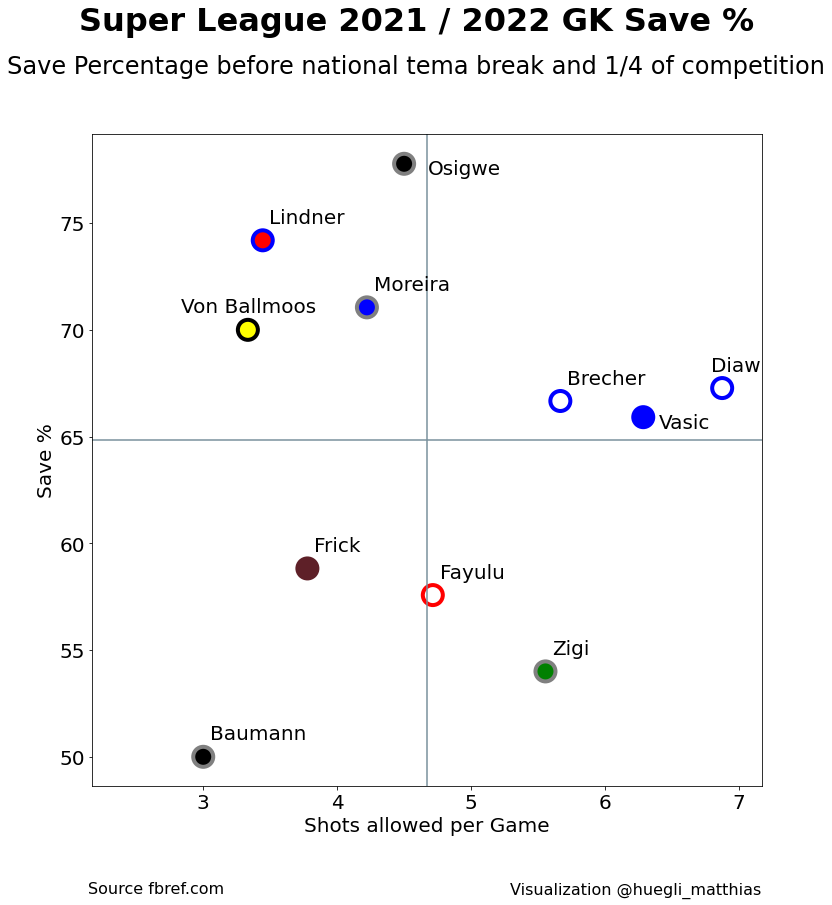

In [143]:
fig = plt.figure(figsize=(12,12))
kwargs = {'palette': color_dict, 'edgecolor': shots_saves_21_22.secondary_color, 'linewidth': 4}

graph = sns.scatterplot(x='shots_faced_mean', y='save_perc', s=400, data=shots_saves_21_22, legend=False, hue='goalkeeper', **kwargs)

for i in range(shots_saves_21_22.shape[0]):
    plt.text(x=shots_saves_21_22.shots_faced_mean[i]+label_xpos[i], 
        y=shots_saves_21_22.save_perc[i]+label_ypos[i], 
        s=shots_saves_21_22.goalkeeper[i], 
        fontsize=20,
        bbox=dict(facecolor='gray', alpha=0))

#sns.despine()
graph.axhline(shots_saves_21_22.save_perc.mean(), color='#78909C')
graph.axvline(shots_saves_21_22.shots_faced_mean.mean(), color='#78909C')

plt.xlim(shots_saves_21_22.shots_faced_mean.mean()-2.5, shots_saves_21_22.shots_faced_mean.mean()+2.5)

#plt.title('Super League 2020 / 2021 Torhüter Abwehrquote \n Nur Daten von Torhüter mit 9 Spielen oder mehr, Quelle fbref.com', fontsize=24)
plt.xlabel('Shots allowed per Game', fontsize=20)
plt.ylabel('Save %', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.text(0.5, 1, 'Super League 2021 / 2022 GK Save %', ha='center', fontsize=32, fontweight='bold')
fig.text(0.5, 0.95, 'Save Percentage before national tema break and 1/4 of competition', ha='center', fontsize=24)
fig.text(0.12, 0.001, 'Source fbref.com', ha='left', fontsize=16)
fig.text(0.9, 0.001, 'Visualization @huegli_matthias', ha='right', fontsize=16)

#plt.savefig('SuperLeague21_22_GK_SavePercentage.png')
plt.show()

plt.show()